# Viral Tweet Predictor

## Load Library and Scraped Twitter Datasets

Tweets scraped from Fox, CNN, and BBC news stations twitter accounts

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression
import re
import datetime
import time
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.preprocessing import RobustScaler
from matplotlib import pyplot as plt

def clean(txt):
    txt = re.sub(r"https?.*", "", txt)
    txt = re.sub(r"^[A-Z ]*:", "", txt)
    txt = re.sub(r"[^A-Za-z]+", " ", txt)
    return txt.strip()

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rudger_dame1/nltk_data...


In [2]:
cnn = pd.read_csv("CNN.csv", sep='\t')
cnn["cat"] = 1
fox = pd.read_csv("FOX.csv", sep='\t')
fox["cat"] = 0
bbc = pd.read_csv("BBC.csv", sep='\t')
bbc["cat"] = 2

data = pd.concat([cnn, fox, bbc])
data2 = data.sample(frac=1)
data = data2[:len(data2)//10]
seconds_in_day = 24*60*60
data.head(2)

/var/folders/h8/4j63wsn97kj91kz6yf13nqp410k4rg/T/ipykernel_32993/643705996.py:1: DtypeWarning: Columns (22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  cnn = pd.read_csv("CNN.csv", sep='\t')
/var/folders/h8/4j63wsn97kj91kz6yf13nqp410k4rg/T/ipykernel_32993/643705996.py:3: DtypeWarning: Columns (22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  fox = pd.read_csv("FOX.csv", sep='\t')
/var/folders/h8/4j63wsn97kj91kz6yf13nqp410k4rg/T/ipykernel_32993/643705996.py:5: DtypeWarning: Columns (22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  bbc = pd.read_csv("BBC.csv", sep='\t')


,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,cat
119253,262759167511642112,262759167511642112,2012-10-28 21:34:02 Mountain Daylight Time,2012-10-28,21:34:02,-600,742143,bbcworld,BBC News (World),NaN,"""Don't try to be a hero,"" New Jersey's governor warns residents as Hurricane #Sandy nears US east coast http://t.co/ytRlrqAi #frankenstorm",en,[],['http://bbc.in/TOcrON'],[],10,99,9,"['sandy', 'frankenstorm']",[],https://twitter.com/BBCWorld/status/262759167511642112,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,2
301194,1113057301,1113057301,2009-01-12 06:47:07 Mountain Standard Time,2009-01-12,06:47:07,-600,1367531,foxnews,Fox News,NaN,HEALTH: Got Bugs? Many Foods Colored With Beetle Extract http://tinyurl.com/9xutw4,en,[],[],[],0,0,0,[],[],https://twitter.com/FoxNews/status/1113057301,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,0


# Clean Data and Create New Features
Added Features:
- time of tweet (ex. year, day, hour, and sec)
- length of tweet
- number of words
- number of capitalized words
- ratio of capitalized words to number of words
- sentiment analysis
- number of hashtags
- if the tweet had a video or thumbnail

In [3]:
timestamps = data["time"].fillna("23:59:59").values
datestamps = data["date"].replace(r"http:.*", "2020-01-01", regex=True).values

data.head(2)

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,cat
119253,262759167511642112,262759167511642112,2012-10-28 21:34:02 Mountain Daylight Time,2012-10-28,21:34:02,-600,742143,bbcworld,BBC News (World),NaN,"""Don't try to be a hero,"" New Jersey's governor warns residents as Hurricane #Sandy nears US east coast http://t.co/ytRlrqAi #frankenstorm",en,[],['http://bbc.in/TOcrON'],[],10,99,9,"['sandy', 'frankenstorm']",[],https://twitter.com/BBCWorld/status/262759167511642112,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,2
301194,1113057301,1113057301,2009-01-12 06:47:07 Mountain Standard Time,2009-01-12,06:47:07,-600,1367531,foxnews,Fox News,NaN,HEALTH: Got Bugs? Many Foods Colored With Beetle Extract http://tinyurl.com/9xutw4,en,[],[],[],0,0,0,[],[],https://twitter.com/FoxNews/status/1113057301,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,0


In [4]:
data["day_frac"] = [(60*60*int(i.split(":")[0]) + 60*int(i.split(":")[1]) + int(i.split(":")[2]))/seconds_in_day for i in timestamps]
data["sin_day"] = [np.sin(i * 2*np.pi) for i in data["day_frac"].values]
data["cos_day"] = [np.cos(i * 2*np.pi) for i in data["day_frac"].values]
data["seconds"] = [int(i.split(":")[2])/60 for i in timestamps]
data["minutes"] = [int(i.split(":")[1])/60 for i in timestamps]
data["hours"] = [int(i.split(":")[0])/24 for i in timestamps]
data["year"] = [int(i.split("-")[0]) for i in datestamps]
data["month"] = [int(i.split("-")[1]) for i in datestamps]
data["day"] = [int(i.split("-")[2]) for i in datestamps]
data["unix_time"] = [time.mktime(datetime.datetime(i[2], i[1], i[0]).timetuple())/1000000000 for i in zip(data.day.values, data.month.values, data.year.values)]
data["cleaned_tweet"] = [clean(txt) for txt in data.tweet.fillna("").values]
data["length"] = [len(i) for i in data["cleaned_tweet"].values]
data["num_words"] = [len(i.split(" ")) for i in data.cleaned_tweet.values]
data["num_caps"] = [len(i) for i in data["cleaned_tweet"].replace(r"[^A-Z]","", regex=True)]
data["cap_word_frac"] = (data["num_caps"] / data["num_words"]).replace(np.inf,-1).replace(np.nan, -2)
data["num_hashtag"] = [len(i.split(",")) if i != '[]' else 0 for i in data['hashtags']]
data["thumbn"] = ~data["thumbnail"].isna()
data["thumbn"] = data["thumbn"].astype(int)
data.head(3)


/var/folders/h8/4j63wsn97kj91kz6yf13nqp410k4rg/T/ipykernel_32993/3680701753.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["day_frac"] = [(60*60*int(i.split(":")[0]) + 60*int(i.split(":")[1]) + int(i.split(":")[2]))/seconds_in_day for i in timestamps]
/var/folders/h8/4j63wsn97kj91kz6yf13nqp410k4rg/T/ipykernel_32993/3680701753.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["sin_day"] = [np.sin(i * 2*np.pi) for i in data["day_frac"].values]
/var/folders/h8/4j63wsn97kj91kz6yf13nqp410k4rg/T/

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,cat,day_frac,sin_day,cos_day,seconds,minutes,hours,year,month,day,unix_time,cleaned_tweet,length,num_words,num_caps,cap_word_frac,num_hashtag,thumbn
119253,262759167511642112,262759167511642112,2012-10-28 21:34:02 Mountain Daylight Time,2012-10-28,21:34:02,-600,742143,bbcworld,BBC News (World),NaN,"""Don't try to be a hero,"" New Jersey's governor warns residents as Hurricane #Sandy nears US east coast http://t.co/ytRlrqAi #frankenstorm",en,[],['http://bbc.in/TOcrON'],[],10,99,9,"['sandy', 'frankenstorm']",[],https://twitter.com/BBCWorld/status/262759167511642112,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,2,0.898634,-0.594706,0.803943,0.033333,0.566667,0.875,2012,10,28,1.351400,Don t try to be a hero New Jersey s governor warns residents as Hurricane Sandy nears US east coast,99,20,7,0.35,2,0
301194,1113057301,1113057301,2009-01-12 06:47:07 Mountain Standard Time,2009-01-12,06:47:07,-600,1367531,foxnews,Fox News,NaN,HEALTH: Got Bugs? Many Foods Colored With Beetle Extract http://tinyurl.com/9xutw4,en,[],[],[],0,0,0,[],[],https://twitter.com/FoxNews/status/1113057301,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,0,0.282720,0.978942,-0.204140,0.116667,0.783333,0.250,2009,1,12,1.231740,Got Bugs Many Foods Colored With Beetle Extract,47,8,8,1.00,0,0
270668,2655591041,2655591041,2009-07-15 12:42:21 Mountain Daylight Time,2009-07-15,12:42:21,-600,1367531,foxnews,Fox News,NaN,WORLD: Up to 14 Killed in Pakistan's Swat Valley. Pakistan's military sought to reassure refugees... http://tinyurl.com/mv7thv,en,[],[],[],0,0,0,[],[],https://twitter.com/FoxNews/status/2655591041,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,0,0.529410,-0.183737,-0.982975,0.350000,0.700000,0.500,2009,7,15,1.247634,Up to Killed in Pakistan s Swat Valley Pakistan s military sought to reassure refugees,86,15,6,0.40,0,0


### Sentiment analysis on tweeted text

In [5]:
sia = SentimentIntensityAnalyzer()
sentiments = [sia.polarity_scores(twt) for twt in tqdm(data.cleaned_tweet.values)]
data["neu"] = [d["neu"] for d in sentiments]
data["neg"] = [d["neg"] for d in sentiments]
data["pos"] = [d["pos"] for d in sentiments]
data["com"] = [d["compound"] for d in sentiments]

100%|███████████████████████████████████| 92288/92288 [00:16<00:00, 5760.15it/s]
/var/folders/h8/4j63wsn97kj91kz6yf13nqp410k4rg/T/ipykernel_32993/3868843999.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["neu"] = [d["neu"] for d in sentiments]
/var/folders/h8/4j63wsn97kj91kz6yf13nqp410k4rg/T/ipykernel_32993/3868843999.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["neg"] = [d["neg"] for d in sentiments]
/var/folders/h8/4j63wsn97kj91kz6yf13nqp410k4rg/T/ipykernel_32993/3868843999.py:5: Set

## Quantify a Viral Tweet 

To quantify how viral a tweet is, we took the natural log of the number of tweets. We expect the viral nature of a tweet to 
increase in popularity at an exponential scale rather than at a linear rate.

In [6]:
# Tke the natural log of likes and make zero likes equal to -1
data["viral"] = [np.log(i) if i !=0 else -1 for i in data['likes_count'].values]


/var/folders/h8/4j63wsn97kj91kz6yf13nqp410k4rg/T/ipykernel_32993/3053881459.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["viral"] = [np.log(i) if i !=0 else -1 for i in data['likes_count'].values]


In [7]:
columns1 = ["day_frac","neu", "neg", "pos", "com", "sin_day","cos_day","seconds","minutes","hours","month","day","cleaned_tweet", "length", "num_words", "num_caps", "cap_word_frac","num_hashtag","cat","thumbn"]
columns2 = ["day_frac","neu", "neg", "pos", "com", "sin_day","cos_day","seconds","minutes","hours","month","day","cleaned_tweet", "length", "num_words", "num_caps", "cap_word_frac","num_hashtag","cat","thumbn","likes_count","retweets_count","replies_count"]

data_short = data[columns1]
data_corr = data[columns2]


## Count Amount of Common Words

In [8]:
vectorizer = CountVectorizer(stop_words="english", max_df=0.1, max_features=50)
vectorizer.fit(data_short["cleaned_tweet"])
temp_data = vectorizer.transform(data_short["cleaned_tweet"])

In [9]:
df = pd.DataFrame(data=temp_data.toarray(),columns=[f"{i}_vocab" for i in vectorizer.get_feature_names()])
df.describe()


/Users/rudger_dame1/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,according_vocab,american_vocab,amp_vocab,attack_vocab,china_vocab,city_vocab,cnn_vocab,coronavirus_vocab,country_vocab,court_vocab,day_vocab,death_vocab,don_vocab,donald_vocab,election_vocab,going_vocab,government_vocab,home_vocab,house_vocab,just_vocab,killed_vocab,like_vocab,live_vocab,man_vocab,new_vocab,news_vocab,north_vocab,obama_vocab,officials_vocab,old_vocab,people_vocab,police_vocab,potus_vocab,president_vocab,realdonaldtrump_vocab,report_vocab,said_vocab,say_vocab,says_vocab,school_vocab,south_vocab,state_vocab,time_vocab,trump_vocab,week_vocab,white_vocab,woman_vocab,world_vocab,year_vocab,years_vocab
count,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000,92288.000000
mean,0.013024,0.014921,0.017142,0.013003,0.013989,0.011887,0.015484,0.013989,0.015257,0.014520,0.016123,0.013252,0.012645,0.011843,0.013425,0.013534,0.014238,0.012049,0.023611,0.015018,0.016546,0.012298,0.012103,0.023394,0.056443,0.015592,0.015094,0.024424,0.011876,0.014812,0.037741,0.030166,0.020111,0.066173,0.018572,0.015755,0.017478,0.025897,0.060203,0.012190,0.012093,0.021465,0.017305,0.074777,0.012396,0.015322,0.012363,0.022820,0.030069,0.017716
std,0.113666,0.127169,0.141695,0.116027,0.125041,0.112786,0.127612,0.119457,0.127427,0.124242,0.131177,0.116139,0.120599,0.108980,0.119522,0.125524,0.122252,0.113392,0.160507,0.124705,0.128494,0.114648,0.111604,0.156714,0.241962,0.128192,0.125605,0.157969,0.109225,0.125033,0.199839,0.181018,0.141074,0.267402,0.135009,0.128045,0.135755,0.160391,0.242734,0.119926,0.112331,0.152437,0.135618,0.276567,0.113736,0.127164,0.113119,0.154676,0.178533,0.133957
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [10]:
new_data = pd.concat([df, data_short.reset_index().drop("index", axis=1)], axis=1)
new_data.head(2)

,according_vocab,american_vocab,amp_vocab,attack_vocab,china_vocab,city_vocab,cnn_vocab,coronavirus_vocab,country_vocab,court_vocab,day_vocab,death_vocab,don_vocab,donald_vocab,election_vocab,going_vocab,government_vocab,home_vocab,house_vocab,just_vocab,killed_vocab,like_vocab,live_vocab,man_vocab,new_vocab,news_vocab,north_vocab,obama_vocab,officials_vocab,old_vocab,people_vocab,police_vocab,potus_vocab,president_vocab,realdonaldtrump_vocab,report_vocab,said_vocab,say_vocab,says_vocab,school_vocab,south_vocab,state_vocab,time_vocab,trump_vocab,week_vocab,white_vocab,woman_vocab,world_vocab,year_vocab,years_vocab,day_frac,neu,neg,pos,com,sin_day,cos_day,seconds,minutes,hours,month,day,cleaned_tweet,length,num_words,num_caps,cap_word_frac,num_hashtag,cat,thumbn
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.898634,0.75,0.07,0.18,0.4939,-0.594706,0.803943,0.033333,0.566667,0.875,10,28,Don t try to be a hero New Jersey s governor warns residents as Hurricane Sandy nears US east coast,99,20,7,0.35,2,2,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.282720,1.00,0.00,0.00,0.0000,0.978942,-0.204140,0.116667,0.783333,0.250,1,12,Got Bugs Many Foods Colored With Beetle Extract,47,8,8,1.00,0,0,0


## Correlation between the Data's features

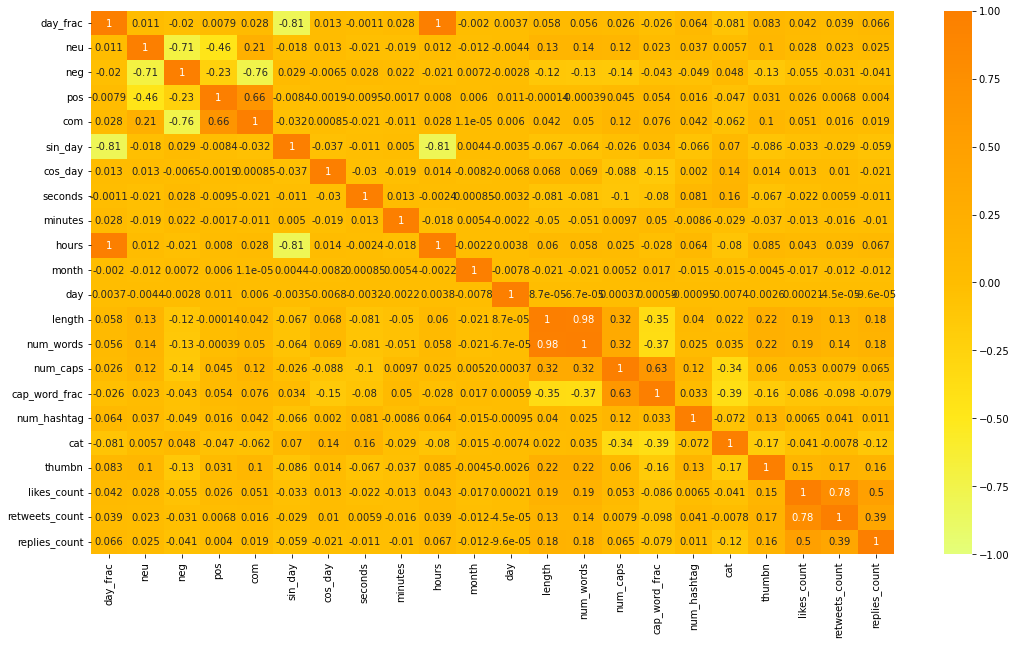

In [11]:
import seaborn as sb
plt.figure(figsize = (18,10))
corr = data_corr.corr()
sb.heatmap(corr, cmap = 'Wistia', vmin=-1, vmax=1,annot= True)
plt.show(sb)

## Split and Scale Data

In [52]:

del new_data["cleaned_tweet"]
X_train, X_test, y_train, y_test = train_test_split(new_data, data["viral"], test_size=0.2, random_state=42)


In [53]:
rc = RobustScaler()
X_train = rc.fit_transform(X_train.astype(np.float))
X_test= rc.transform(X_test.astype(np.float))

C:\Users\rudger_dame1\AppData\Local\Temp\ipykernel_348404\2028186727.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train = rc.fit_transform(X_train.astype(np.float))
C:\Users\rudger_dame1\AppData\Local\Temp\ipykernel_348404\2028186727.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test= rc.transform(X_test.astype(np.float))

## Linear, RandomForest and Multi-layer Perceptron Regressions

The RandomForest regression seems to have them best fit.

In [54]:

lr = LinearRegression().fit(X_train,y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

#print score
print("lr.coef_: {}".format(lr.coef_))
print("lr.intercept_: {}".format(lr.intercept_))
print('lr train score %.3f, lr test score: %.3f' % (
lr.score(X_train,y_train),
lr.score(X_test, y_test)))


lr.coef_: [ 5.00614918e-01  1.54551489e-01  1.07528259e-01  2.10647365e-01
 -2.19248339e-01  1.63117685e-01  3.63904066e-01  1.50207451e+00
  1.02003672e-01 -2.86595305e-01  1.04668710e-01  4.70981102e-03
  2.32870371e-01  3.58350428e-02  2.43040056e-02 -7.76703684e-01
  2.07341484e-03 -7.66396273e-02 -8.04889812e-02  3.17193186e-01
 -2.77132423e-01  2.28490498e-01 -9.70441258e-03  3.36326189e-02
  1.48057475e-01  3.04057216e-01  6.13223363e-02 -2.09075997e-01
 -4.08804322e-01  4.09140912e-01 -5.93617110e-02 -5.54184972e-02
  1.60987893e+00 -9.55753821e-02  1.02284824e+00 -1.44300567e-01
  4.18038961e-01 -3.01412644e-01 -1.70349778e-01  3.09906771e-01
  7.52549323e-02 -1.37123705e-01  1.99658244e-01  1.23095509e+00
  1.01372069e-01  2.89902521e-01  1.93475751e-01  8.38252472e-02
 -8.40763826e-02  2.74509757e-01 -2.22382748e+11 -7.31860946e-01
 -5.79951699e-01 -3.23523122e-01  4.97814600e-02 -1.36216995e-01
  1.06678227e-01  1.83702628e+08  1.10221577e+10  2.20443154e+11
 -1.74736380e-0

In [55]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(random_state=1, max_iter=1000)

#fit model
regr.fit(X_train,y_train.values.ravel())
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)

#print score
print('Multi-layer Perceptron train score %.3f, Multi-layer Perceptron test score: %.3f' % (
regr.score(X_train,y_train),
regr.score(X_test, y_test)))

Multi-layer Perceptron train score 0.791, Multi-layer Perceptron test score: 0.746


In [56]:

forest = RFR(n_estimators=1000,
                     max_depth=20,
                     min_samples_split=2,
                     min_samples_leaf= 1,
                     bootstrap=True,
                     oob_score=False)

#fit model
forest.fit(X_train,y_train.values.ravel())
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

#print score
print('forest train score %.3f, forest test score: %.3f' % (
forest.score(X_train,y_train),
forest.score(X_test, y_test)))


forest train score 0.913, forest test score: 0.784


### Feature Importances

In [57]:
importance = pd.DataFrame({"Importance":forest.feature_importances_, "name": list(new_data.columns)}).sort_values("Importance", ascending=False)
importance

,Importance,name
68,0.312534,thumbn
62,0.249035,length
65,0.117543,cap_word_frac
67,0.071306,cat
63,0.031327,num_words
...,...,...
11,0.000228,death_vocab
20,0.000216,killed_vocab
3,0.000190,attack_vocab
36,0.000185,said_vocab


### Random Forest Grid Search

In [19]:
from sklearn.model_selection import GridSearchCV
#Function to print best hyperparamaters: 
def print_best_params(gd_model):
    param_dict = gd_model.best_estimator_.get_params()
    model_str = str(gd_model.estimator).split('(')[0]
    print("\n*** {} Best Parameters ***".format(model_str))
    for k in param_dict:
        print("{}: {}".format(k, param_dict[k]))
    print()



###Random Forest parameter grid###
param_grid_rf = dict(n_estimators=[100, 1000],
                     max_depth=[2, 20, 40],
                     min_samples_split=[2],
                     min_samples_leaf= np.arange(1, 30, 10, int),
                     bootstrap=[True, False],
                     oob_score=[False, ])


forest = GridSearchCV(RFR(random_state=0), param_grid=param_grid_rf, cv=2, verbose=3)

#fit model
forest.fit(X_train,y_train.values.ravel())


#print score
print('\n\nforest train score %.3f, forest test score: %.3f' % (
forest.score(X_train,y_train),
forest.score(X_test, y_test)))

print_best_params(forest)


Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV 1/2] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False;, score=0.440 total time=  36.6s
[CV 2/2] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False;, score=0.480 total time=  36.7s
[CV 1/2] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, oob_score=False;, score=0.444 total time= 6.1min
[CV 2/2] END bootstrap=True, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, oob_score=False;, score=0.485 total time= 6.1min
[CV 1/2] END bootstrap=True, max_depth=2, min_samples_leaf=11, min_samples_split=2, n_estimators=100, oob_score=False;, score=0.440 total time=  36.4s
[CV 2/2] END bootstrap=True, max_depth=2, min_samples_leaf=11, min_samples_split=2, n_estimators=100, oob_score=False;, score=0.480 total time=  36.4s
[CV 1/2] END bootstrap=True, max_de

[CV 1/2] END bootstrap=False, max_depth=20, min_samples_leaf=11, min_samples_split=2, n_estimators=1000, oob_score=False;, score=0.709 total time=44.5min
[CV 2/2] END bootstrap=False, max_depth=20, min_samples_leaf=11, min_samples_split=2, n_estimators=1000, oob_score=False;, score=0.714 total time=43.0min
[CV 1/2] END bootstrap=False, max_depth=20, min_samples_leaf=21, min_samples_split=2, n_estimators=100, oob_score=False;, score=0.731 total time= 4.3min
[CV 2/2] END bootstrap=False, max_depth=20, min_samples_leaf=21, min_samples_split=2, n_estimators=100, oob_score=False;, score=0.730 total time= 4.0min
[CV 1/2] END bootstrap=False, max_depth=20, min_samples_leaf=21, min_samples_split=2, n_estimators=1000, oob_score=False;, score=0.731 total time=43.1min
[CV 2/2] END bootstrap=False, max_depth=20, min_samples_leaf=21, min_samples_split=2, n_estimators=1000, oob_score=False;, score=0.730 total time=40.5min
[CV 1/2] END bootstrap=False, max_depth=40, min_samples_leaf=1, min_samples_sp